# Task 1: Gender Classification from audio files

In [580]:
import os
import json
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from libs.helper import get_mfcc_features

In [2]:
data_dir = './LibriSpeech'
info_path = './data/info.csv'

assert os.path.exists(data_dir), 'Data directory not found'
assert os.path.exists(info_path), 'Info file not found, please run preprocess.ipynb first'
info = pd.read_csv(info_path)

In [248]:
class LibriSpeechData(Dataset):
    def __init__(self, info, metadata=None, data_dir='./LibriSpeech', max_len=None, n_mfcc=13):
        if metadata is None:
            self.info = info
        else:
            self.info = info[info['speaker_id'].isin(metadata)]
        self.data_dir = data_dir
        self.max_len = max_len
        self.n_mfcc = n_mfcc

        self.sex_dict = {'M': 0, 'F': 1}

    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        sample = self.info.iloc[idx]
        
        speaker_id = sample['speaker_id']
        transcript = sample['transcript']
        sex = sample['sex']

        audio_path = f'{self.data_dir}/{sample["audio_path"]}'
        mfcc_features = get_mfcc_features(audio_path, n_mfcc=self.n_mfcc)

        if self.max_len is not None:
            if mfcc_features.shape[-1] < self.max_len:
                mfcc_features = np.pad(mfcc_features, ((0, 0), (0, self.max_len - mfcc_features.shape[-1])), 'constant')
            else:
                mfcc_features = mfcc_features[:, :self.max_len]

        label = self.sex_dict[sex]
        return mfcc_features, label, (speaker_id, transcript)

In [249]:
n_mfcc = 40
dataset = LibriSpeechData(info, data_dir=data_dir, n_mfcc=n_mfcc)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

### MFCC Features

Mel-Frequency Cepstral Coefficients (MFCCs) are widely used in speech and audio processing to represent the spectral characteristics of a signal. 

The 13 MFCC features refer to the first 13 coefficients extracted from the MFCC representation of an audio signal.

MFCCs vs. Raw Spectrograms:
* A raw spectrogram captures exact frequency details.
* MFCCs extract the overall shape (spectral envelope) without fine-grained variations.

In [58]:
for mfcc_features, label, (speaker_id, transcript) in tqdm.tqdm(dataloader):
    mfcc_features = mfcc_features.squeeze(0)
    break

  0%|          | 0/2703 [00:00<?, ?it/s]


Sample MFCC features

* MFCC0 is often associated with the loudness of the audio (represented in log scale)
    $$
    MFCC0 = \log\sum_i S[i]
    $$
    , where $S[i]$ is the power spectrum in the i-th Mel filter.
    * If the singal has near-zero energy, MFCC0 will approaches a large negative value
* MFCC1-: Spectral Shape (**formant information**)
    * Derives from the the **spectral envelope** of speech
    * Represent how energy is distributed across different frequency bands

Terms: 
1. Formant Information: Peaks in the frequency spectrum of speech that correspond to resonant frequencies of the vocal tract.
    * Male voices often has a lower formants (~300-800 Hz for F1, ~800-2000 Hz for F2) compare to female voices (~350-900 Hz for F1, ~900-2500 Hz for F2)
2. Spectral Envelope: The smooth curve that outlines the peaks of the frequency spectrum of speech, which shows an overall shape of the frequency distribution.

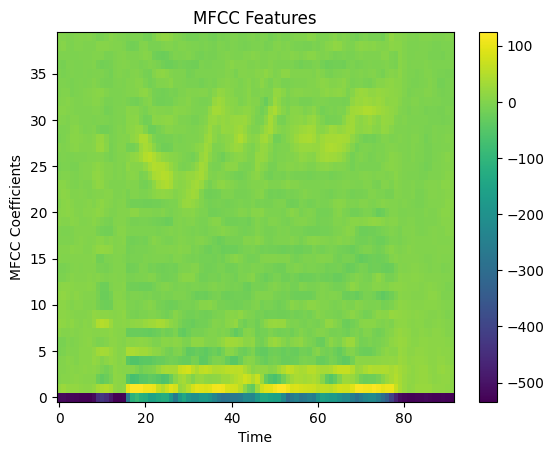

In [59]:
plt.imshow(mfcc_features.numpy(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.title('MFCC Features')
plt.show()

### Data Analysis

#### 1. Average MFCC

Since the MFCC graph is related to the recording's duration, we can calculate the average MFCC feature to obtain a compact representation of the overall spectral characteristics of the audio. 

This helps in tasks such as speaker identification, emotion recognition, and music classification, where a fixed-size feature vector is needed instead of a time-dependent representation.

In [60]:
average_mfccs = []
gender_labels = []
speaker_ids = []
lengths = []
for mfcc_features, label, (speaker_id, transcript) in tqdm.tqdm(dataloader):
    average_mfccs.append(mfcc_features.numpy().squeeze(0).mean(axis=-1))
    gender_labels.append(label.item())
    speaker_ids.append(speaker_id.item())
    lengths.append(mfcc_features.shape[-1])

average_mfccs = np.array(average_mfccs)
gender_labels = np.array(gender_labels)
speaker_ids = np.array(speaker_ids)

avg_mfcc_df = {
    'speaker_id': speaker_ids,
    'gender_labels': gender_labels,
    'mfccs': average_mfccs.tolist(),
    'lengths': lengths
}

avg_mfcc_df = pd.DataFrame(avg_mfcc_df)

100%|██████████| 2703/2703 [01:11<00:00, 37.69it/s]


In [61]:
print("Number of speakers:", len(avg_mfcc_df['speaker_id'].unique()))
print(" - male (0):", len(avg_mfcc_df[avg_mfcc_df['gender_labels'] == 0]['speaker_id'].unique()))
print(" - female (1):", len(avg_mfcc_df[avg_mfcc_df['gender_labels'] == 1]['speaker_id'].unique()))
print("")
print("Number of samples", len(avg_mfcc_df))
print(avg_mfcc_df.head())

Number of speakers: 40
 - male (0): 20
 - female (1): 20

Number of samples 2703
   speaker_id  gender_labels  \
0        1988              1   
1        6241              0   
2        2428              0   
3        5338              1   
4        7976              0   

                                               mfccs  lengths  
0  [-300.59454345703125, 136.97328186035156, -21....      121  
1  [-257.9820556640625, 90.51004791259766, -13.07...      125  
2  [-348.24359130859375, 96.13388061523438, -11.1...       98  
3  [-323.1188659667969, 74.94914245605469, -14.16...      352  
4  [-326.4638366699219, 63.52449417114258, -17.73...      314  


#### 2. Preprocess

MFCC0 represents the loudness of speech and can be on a different scale compared to other MFCC features. Additionally, its variance across different audio samples can be significantly high. Therefore, applying normalization to each MFCC feature is necessary to better observe distribution differences and ensure fair comparisons. In here, we use z-score normalization.

In [62]:
scaler = StandardScaler()
mfcc_norm = scaler.fit_transform(avg_mfcc_df['mfccs'].values.tolist())
mean = scaler.mean_
std = np.sqrt(scaler.var_)
print("Normalization Mean: ", mean)
print("Normalization Std: ", std)

Normalization Mean:  [-3.13638786e+02  8.49510116e+01 -2.81166738e+00  2.22463581e+01
 -5.55616697e+00 -2.83044622e+00 -1.00404093e+01 -7.32355966e+00
 -2.42629774e+00 -3.82546123e+00 -3.68130851e+00 -1.01913592e-01
 -1.77995815e+00 -1.77137550e+00 -2.90862451e+00 -2.00173048e+00
 -4.00558465e+00 -2.30321530e+00 -3.48198180e+00 -2.69742827e+00
 -2.27432087e+00 -1.30720481e+00 -1.30535371e+00 -3.60352180e-01
 -7.60919230e-01  2.80804248e-01  2.66407287e-01 -1.13602287e-02
  7.92303240e-01  4.87033426e-01  7.46334020e-01  7.52476726e-01
  7.59285064e-01  7.78530084e-01  5.90919646e-01  5.13856144e-01
  5.97042048e-02  7.67871008e-02 -3.37505368e-01 -2.67098310e-01]
Normalization Std:  [50.87216346 21.35392629 21.88119824 12.51647084 13.38147637 12.84674121
 10.33070226  8.59203869  5.79758738  5.59034657  6.16790535  4.2871773
  5.78269072  6.23838931  4.94364742  4.30811523  4.6111428   3.9040291
  4.16609972  3.53390662  3.85826133  3.71035677  3.31749653  4.07834689
  3.58751397  3.59

#### 3. Data Distribution and Outliers

In this section, we examine the average MFCC distribution across all samples using tSNE. We also analyze whether the data contains outliers. Since we are working with multivariate data (N, D), instead of using z-score to determine outliers, we use Mahalanobis Distances.

Univariate Z-score:
$$
z_i = \frac{x_i - \bar x}{\sigma}
$$

Mahalanobis Distance: (Replace the univariate mean with multivariate mean and standard deviation with covariance matrix)
$$
D_M = \sqrt{(x-\mu)^T\Sigma^{-1}(x-\mu)}
$$

In [516]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X = tsne.fit_transform(mfcc_norm)
y = avg_mfcc_df['gender_labels'].values
sy = avg_mfcc_df['speaker_id'].values

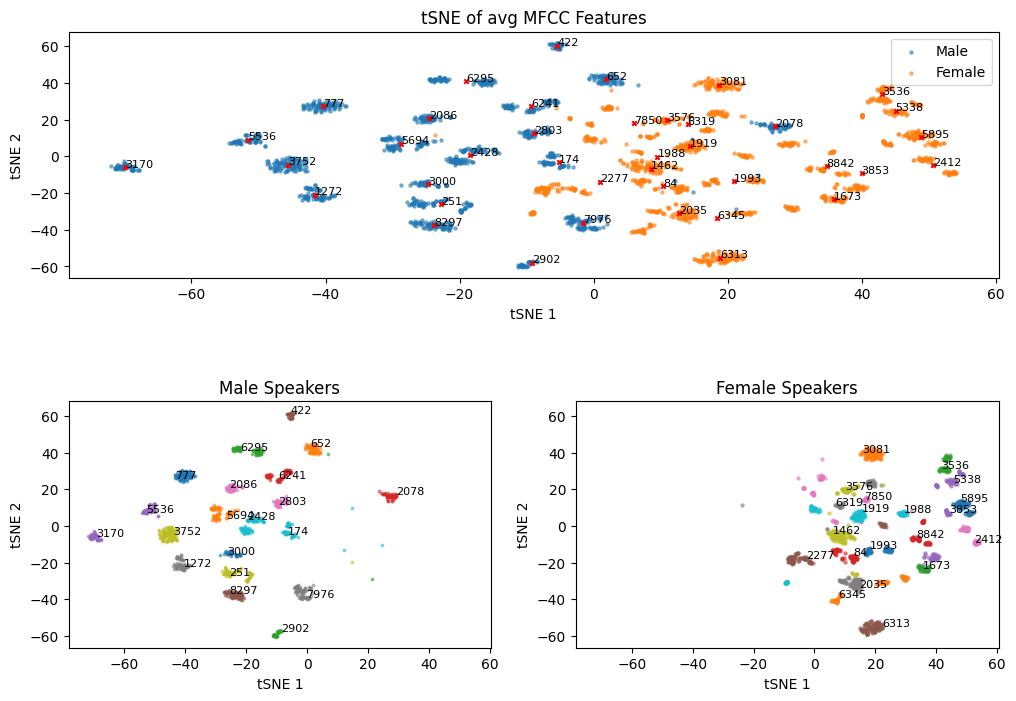

In [526]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
# combine axes
ax1.scatter(X[y == 0, 0], X[y==0, 1], label='Male', alpha=0.5, s=5)
ax1.scatter(X[y == 1, 0], X[y==1, 1], label='Female', alpha=0.5, s=5)
for i in list(set(sy)):
    pos = np.where(sy == i)[0]
    centroid = np.mean(X[pos], axis=0)
    ax1.scatter(centroid[0], centroid[1], s=10, marker='x', color='red')
    ax1.text(centroid[0], centroid[1], str(i), fontsize=8)
ax1.legend()
ax1.set_xlabel('tSNE 1')
ax1.set_ylabel('tSNE 2')
ax1.set_title('tSNE of avg MFCC Features')

# Bottom row: Two separate plots
ax2 = fig.add_subplot(gs[1, 0])
for i in list(set(sy[y==0])):
    pos = np.where(sy == i)[0]
    ax2.scatter(X[pos, 0], X[pos, 1], s=3, alpha=0.5)
    ax2.text(X[pos[0], 0], X[pos[0], 1], str(i), fontsize=8)
ax2.set_xlabel('tSNE 1')
ax2.set_ylabel('tSNE 2')
ax2.set_title('Male Speakers')
ax2.sharex(ax1)
ax2.sharey(ax1)

ax3 = fig.add_subplot(gs[1, 1])
for i in list(set(sy[y==1])):
    pos = np.where(sy == i)[0]
    ax3.scatter(X[pos, 0], X[pos, 1], s=5, alpha=0.5)
    ax3.text(X[pos[0], 0], X[pos[0], 1], str(i), fontsize=8)
ax3.set_xlabel('tSNE 1')
ax3.set_ylabel('tSNE 2')
ax3.set_title('Female Speakers')
ax3.sharex(ax1)
ax3.sharey(ax1)
plt.subplots_adjust(hspace=0.5)
plt.show()

From the tSNE results, we observe that male speakers subject 2902, 2078, and 7976, are positioned farther from other male speakers and locate closer to female speaker region.

In [509]:
def detect_outliers(data, threshold=3):
    mu = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_cov = np.linalg.inv(cov)

    distances = []
    for i in range(data.shape[0]):
        d = np.sqrt((data[i] - mu) @ inv_cov @ (data[i] - mu).T)
        distances.append(d)
    distances = np.array(distances)

    outliers = np.argwhere(np.abs(distances - np.mean(distances)) > threshold * np.std(distances))
    return outliers.flatten() 

In [564]:
print("Male: ")
scaler = StandardScaler()
scaler.fit(avg_mfcc_df['mfccs'].values.tolist())
male_df = avg_mfcc_df[avg_mfcc_df['gender_labels'] == dataset.sex_dict['M']]
male_mfcc_norm = scaler.transform(male_df['mfccs'].values.tolist())
female_df = avg_mfcc_df[avg_mfcc_df['gender_labels'] == dataset.sex_dict['F']]
female_mfcc_norm = scaler.transform(female_df['mfccs'].values.tolist())

male_outlier_indices = detect_outliers(male_mfcc_norm)
male_outlier_df = male_df.iloc[male_outlier_indices]
for speaker_id in male_outlier_df['speaker_id'].unique():
    num_speaker_samples = avg_mfcc_df[avg_mfcc_df['speaker_id'] == speaker_id].shape[0] 
    num_outlier_samples = male_outlier_df[male_outlier_df['speaker_id'] == speaker_id].shape[0]
    print(f"Speaker {speaker_id}: {num_outlier_samples/num_speaker_samples*100:.2f}% outliers")
print("=====================================")
print("Female: ")
female_outlier_indices = detect_outliers(female_mfcc_norm)
female_outlier_df = female_df.iloc[female_outlier_indices]
for speaker_id in female_outlier_df['speaker_id'].unique():
    num_speaker_samples = avg_mfcc_df[avg_mfcc_df['speaker_id'] == speaker_id].shape[0] 
    num_outlier_samples = female_outlier_df[female_outlier_df['speaker_id'] == speaker_id].shape[0]
    print(f"Speaker {speaker_id}: {num_outlier_samples/num_speaker_samples*100:.2f}% outliers")

Male: 
Speaker 7976: 7.69% outliers
Speaker 5694: 3.61% outliers
Speaker 5536: 3.39% outliers
Speaker 251: 1.33% outliers
Speaker 2902: 2.63% outliers
Speaker 174: 1.69% outliers
Female: 
Speaker 6313: 2.08% outliers
Speaker 5338: 3.39% outliers
Speaker 3853: 3.51% outliers
Speaker 6345: 1.30% outliers
Speaker 2035: 1.30% outliers


When detecting outliers using Mahalanobis Distance, we observe that subject 7976 has the highest percentage of outlier points. Both analyses suggest that subject 7976 might be an outlier speaker.

Next, we examine potential outlier speakers by reviewing the SPEAKERS.TXT file and analyzing the corresponding audio recordings. Based on this investigation, we observe that

$$
\begin{array}{c | c | c | c | c}
\hline
\textbf{Subject ID} & \textbf{Gender} & \textbf{Dataset} & \textbf{Minute} & \textbf{Speaker Name} \\
\hline
2078 & M & \text{dev-clean} & 8.03  & \text{Kathy Caver} \\
\hline
7976 & M & \text{dev-clean} & 8.13 & \text{Jennifer Rutters} \\
\hline
\end{array}
$$

Both speakers 2078 and 7976 are labeled as male speakers; however, they should be female speakers. Therefore, we can discard these two speakers.

In [530]:
outlier_subjects = [2078, 7976] 
curated_avg_mfcc_df = avg_mfcc_df[~avg_mfcc_df['speaker_id'].isin(outlier_subjects)]
print("Number of samples before removing outliers:", len(avg_mfcc_df))
print("Number of samples after removing outliers:", len(curated_avg_mfcc_df))


Number of samples before removing outliers: 2703
Number of samples after removing outliers: 2573


#### 4. MFCC Features

In this section, we analyze the differences in MFCC distributions between genders. The following observations can be made:
* The average MFCC0 for females is higher than for males, suggesting that female speech tends to have greater overall energy or loudness compared to male speech.
* Males exhibit higher values for lower-order MFCC features, while females tend to have higher values for higher-order MFCC features. This aligns with the well-established understanding that male voices contain more energy in lower frequencies, whereas female voices emphasize higher frequencies, primarily due to differences in vocal tract length and formant frequencies.

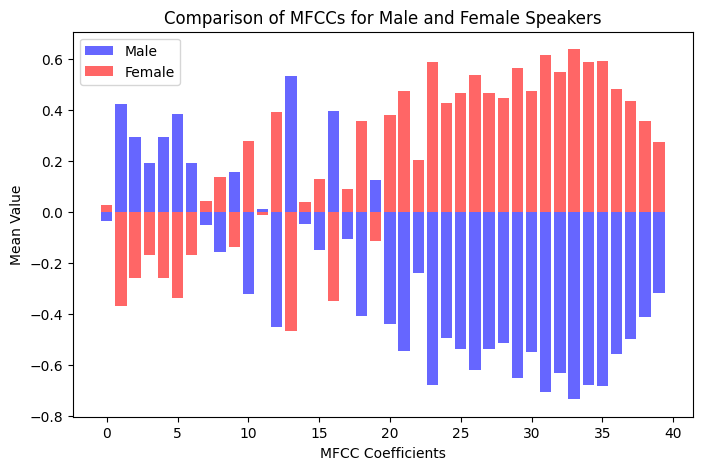

In [533]:
# Plot MFCCs
scaler = StandardScaler()
mfcc_norm = scaler.fit_transform(curated_avg_mfcc_df['mfccs'].values.tolist())

male_mfcc_norm = scaler.transform(curated_avg_mfcc_df[curated_avg_mfcc_df['gender_labels'] == dataset.sex_dict['M']]['mfccs'].values.tolist())
female_mfcc_norm = scaler.transform(curated_avg_mfcc_df[curated_avg_mfcc_df['gender_labels'] == dataset.sex_dict['F']]['mfccs'].values.tolist())

features = range(n_mfcc)
plt.figure(figsize=(8, 5))
plt.bar(features, np.mean(male_mfcc_norm, axis=0), alpha=0.6, label="Male", color="blue")
plt.bar(features, np.mean(female_mfcc_norm, axis=0), alpha=0.6, label="Female", color="red")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Mean Value")
plt.title("Comparison of MFCCs for Male and Female Speakers")
plt.legend()
plt.show()

### Gender Classification

#### 1. Train Test Split (Cross-subject, Stratified K-Folds)

There are several methods for splitting data in a gender classification task. In this study, we use a cross-subject split, ensuring that no subjects overlap between the training and test sets. This approach guarantees a fair evaluation by preventing data leakage, thereby improving generalization and ensuring the model learns speaker-independent gender characteristics rather than memorizing individual voices.

We split the data into training and test sets using the ratio (0.8, 0.2). Stratified (TODO)

In [581]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

subjects_df = curated_avg_mfcc_df.drop_duplicates(subset='speaker_id', keep='first')
X = subjects_df['speaker_id']
y = subjects_df['gender_labels']

train_subjects = []
test_subjects = []

for train_index, val_index in skf.split(X, y):
    train_subjects.append(X.iloc[train_index].values)
    test_subjects.append(X.iloc[val_index].values)


In [582]:
metadata_path = "./data/task1_metadata.json"

if not os.path.exists(metadata_path):
    metadata = {}
    for i in range(len(train_subjects)):
        metadata[f"fold_{i}"] = {
            "train": train_subjects[i].tolist(),
            "test": test_subjects[i].tolist()
        }

    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=4)

else:
    print("metadata already exists")
    with open (metadata_path, "r") as f:
        metadata = json.load(f)

metadata already exists


In [583]:
train_df = info[info['speaker_id'].isin(train_subjects[0])]
test_df = info[info['speaker_id'].isin(test_subjects[0])]

print("Number of train subjects: {} | # male: {} | # female: {}".format(len(train_subjects[0]), len(train_df[train_df['sex'] == 'M']['speaker_id'].unique()), len(train_df[train_df['sex'] == 'F']['speaker_id'].unique())))
print("Number of test subjects: {} | # male: {} | # female: {}".format(len(test_subjects[0]), len(test_df[test_df['sex'] == 'M']['speaker_id'].unique()), len(test_df[test_df['sex'] == 'F']['speaker_id'].unique())))

Number of train subjects: 30 | # male: 14 | # female: 16
Number of test subjects: 8 | # male: 4 | # female: 4


#### 2. Classifiers

In [538]:
class LibriSpeechData_MFCC(Dataset):
    def __init__(self, data, metadata=None, scaler=None):
        self.scaler = scaler
        self.data = data if metadata is None else data[data['speaker_id'].isin(metadata)] 

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row_data = self.data.iloc[idx]
        speaker_id = row_data['speaker_id']
        label = row_data['gender_labels']
        mfcc_features = np.array(row_data['mfccs'])
        if self.scaler is not None:
            mfcc_features = self.scaler.transform(mfcc_features.reshape(1, -1)).flatten()
        return mfcc_features.flatten(), label, speaker_id

##### 2.1 Logistic Regression

Since there is a significant difference in the mean MFCC values between genders, we can design a logistic regression model that uses the average MFCCs as input features for classification.

In [539]:
from sklearn.linear_model import LogisticRegression

class LRModel():
    def __init__(self):
        self.model = LogisticRegression()

    def fit(self, X, y):
        self.model.fit(X, y)
        return 

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
lr_result = []
for fold_id in metadata.keys():
    scaler = StandardScaler()

    train_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(metadata[fold_id]['train'])]
    test_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(metadata[fold_id]['test'])]
    
    scaler.fit(np.stack(train_data['mfccs'].values))
    lr_model = LRModel()

    train_dataset = LibriSpeechData_MFCC(train_data, scaler=scaler)
    test_dataset = LibriSpeechData_MFCC(test_data, scaler=scaler)

    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

    # Train the model
    for mfcc_features, label, speaker_id in train_loader:        
        lr_model.fit(mfcc_features.numpy(), label.numpy())
        break
    
    # Evaluate the model
    for data_type, loader in zip(['train', 'test'], [train_loader, test_loader]):
        for mfcc_features, label, speaker_id in loader:
            preds = lr_model.predict(mfcc_features.numpy())
            labels = label.numpy()    
            
            lr_result.append({
                'data_type': data_type,
                'fold_id': fold_id,
                'speaker_id': speaker_id.numpy(),
                'preds': preds,
                'labels': labels
            })

lr_result_df = pd.DataFrame(lr_result)    

In [584]:
def evaluate(df):
    def calculate_confusion_matrix(preds, labels):
        confusion_matrix = np.zeros((2, 2))
        tp = np.sum(np.logical_and(preds == 1, labels == 1))
        tn = np.sum(np.logical_and(preds == 0, labels == 0))
        fp = np.sum(np.logical_and(preds == 1, labels == 0))
        fn = np.sum(np.logical_and(preds == 0, labels == 1))
        confusion_matrix[0, 0] = tn
        confusion_matrix[0, 1] = fp
        confusion_matrix[1, 0] = fn
        confusion_matrix[1, 1] = tp
        return confusion_matrix
    
    train_result = df[df['data_type'] == 'train']
    test_result = df[df['data_type'] == 'test']

    train_confusion_matrices = []
    test_confusion_matrices = []

    for fold_id in sorted(train_result['fold_id'].unique()):
        train_fold = train_result[train_result['fold_id'] == fold_id]
        test_fold = test_result[test_result['fold_id'] == fold_id]

        train_confusion_matrix = calculate_confusion_matrix(np.concatenate(train_fold['preds'].values), np.concatenate(train_fold['labels'].values))
        test_confusion_matrix = calculate_confusion_matrix(np.concatenate(test_fold['preds'].values), np.concatenate(test_fold['labels'].values))

        train_confusion_matrices.append(train_confusion_matrix)
        test_confusion_matrices.append(test_confusion_matrix)

    train_confusion_matrices = np.stack(train_confusion_matrices)
    test_confusion_matrices = np.stack(test_confusion_matrices)
    
    return train_confusion_matrices, test_confusion_matrices

def plot_confusion_matrix(train_cms, test_cms, title):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))
    # Loop over train and test data
    for i, (data_type, data) in enumerate(zip(['Train', 'Test'], [train_cms, test_cms])):
        # Plot heatmap
        cm = [cm / cm.sum() for cm in data]
        cm = np.mean(cm, axis=0)
        
        sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f"{data_type} Set: Accuracy {cm.trace() * 100:.2f}%")
        axes[i].set_xlabel('Predicted Label', fontsize=12)
        axes[i].set_ylabel('Ground Truth Label', fontsize=12)
        axes[i].set_xticklabels(['Male (0)', 'Female (1)'], fontsize=10)
        axes[i].set_yticklabels(['Male (0)', 'Female (1)'], fontsize=10)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

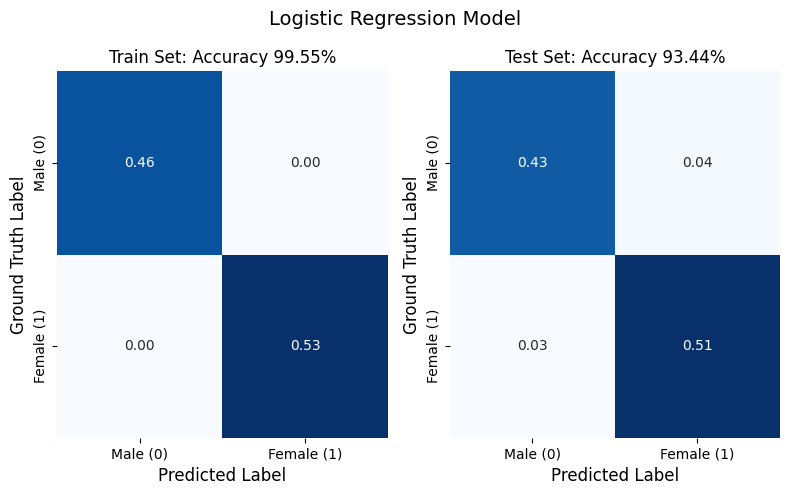

In [585]:
lr_train_cms, lr_test_cms = evaluate(lr_result_df)
plot_confusion_matrix(lr_train_cms, lr_test_cms, "Logistic Regression Model")

##### 2.2 Support Vector Classifier

In [543]:
from sklearn.svm import SVC

class SVMModel():
    def __init__(self):
        self.model = SVC()

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

In [544]:
svm_result = []
for fold_id in metadata.keys():
    scaler = StandardScaler()

    train_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(metadata[fold_id]['train'])]
    test_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(metadata[fold_id]['test'])]
    
    scaler.fit(np.stack(train_data['mfccs'].values))
    svm_model = SVMModel()

    train_dataset = LibriSpeechData_MFCC(train_data, scaler=scaler)
    test_dataset = LibriSpeechData_MFCC(test_data, scaler=scaler)

    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

    # Train the model
    for mfcc_features, label, speaker_id in train_loader:        
        svm_model.fit(mfcc_features.numpy(), label.numpy())
        break
    
    # Evaluate the model
    for data_type, loader in zip(['train', 'test'], [train_loader, test_loader]):
        for mfcc_features, label, speaker_id in loader:
            preds = svm_model.predict(mfcc_features.numpy())
            labels = label.numpy()    
            
            svm_result.append({
                'data_type': data_type,
                'fold_id': fold_id,
                'speaker_id': speaker_id.numpy(),
                'preds': preds,
                'labels': labels
            })

svm_result_df = pd.DataFrame(svm_result)

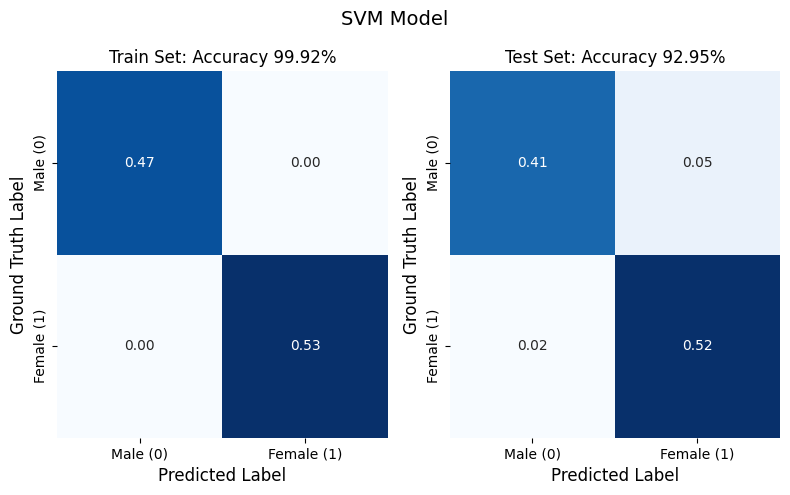

In [586]:
svm_train_cms, svm_test_cms = evaluate(svm_result_df)
plot_confusion_matrix(svm_train_cms, svm_test_cms, "SVM Model")

##### 2.3 CNN Method

Previous naïve machine learning methods achieved an accuracy of approximately 93%. In this section, we explore deep learning approaches to determine whether they can improve classification performance.

In [565]:
class CNNModel(nn.Module):
    def __init__(self, n_mfcc):
        super(CNNModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (n_mfcc // 4), 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1) # (batch_size, 1, n_mfcc)
        x = self.encoder(x)  
        logits = self.classifier(x) 
        return logits
    
    def predict(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            return torch.sigmoid(logits).cpu().numpy()


In [566]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [567]:
cnn_result = [] 
for fold_id in metadata.keys():
    print(f"Training fold {fold_id}")   
    scaler = StandardScaler()

    train_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(metadata[fold_id]['train'])]
    test_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(metadata[fold_id]['test'])]
    
    scaler.fit(np.stack(train_data['mfccs'].values))
    cnn_model = CNNModel(n_mfcc)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(cnn_model.parameters(), lr=1e-3, weight_decay=1e-3, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    cnn_model.to(device)

    train_dataset = LibriSpeechData_MFCC(train_data, scaler=scaler)
    test_dataset = LibriSpeechData_MFCC(test_data, scaler=scaler)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Train the model
    checkpoint_path = f'./checkpoints/cnn_model/{fold_id}.pth'
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    num_epochs = 50
    best_loss = np.inf
    best_epoch = 0
    early_stopping_patience = 10
    for epoch in range(num_epochs):
        cnn_model.train()
        train_loss = []
        for mfcc_features, labels, _ in (train_loader):
            mfcc_features, labels = mfcc_features.float().to(device), labels.to(device)
            optimizer.zero_grad()
            logits = cnn_model(mfcc_features)
            loss = criterion(logits.reshape(-1), labels.float())
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        test_loss = []
        cnn_model.eval()
        with torch.no_grad():
            for mfcc_features, labels, _ in (test_loader):
                mfcc_features, labels = mfcc_features.float().to(device), labels.to(device)
                logits = cnn_model(mfcc_features)
                loss = criterion(logits.reshape(-1), labels.float())
                test_loss.append(loss.item())
        test_loss = np.mean(test_loss)
        scheduler.step(test_loss)
        
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            torch.save({
                'epoch': best_epoch,
                'model_state_dict': cnn_model.state_dict(),
                'loss': test_loss,
                'scaler': scaler,
            }, checkpoint_path)

        print(f"Epoch {epoch+1}/{num_epochs} | train loss: {train_loss:.4f} | test loss: {test_loss:.4f} | lr: {optimizer.param_groups[0]['lr']}")
        if epoch - best_epoch > early_stopping_patience:
            print("Early stopping")
            break

    print("Finished training, save model at epoch: {}".format(best_epoch))
    print("")
    
    # Evaluate the model
    cnn_model.load_state_dict(torch.load(checkpoint_path, weights_only=False)['model_state_dict'])
    cnn_model.eval()
    with torch.no_grad():
        for data_type, loader in zip(['train', 'test'], [train_loader, test_loader]):
            for mfcc_features, labels, speaker_id in loader:
                mfcc_features, labels = mfcc_features.float().to(device), labels.to(device)

                preds = cnn_model.predict(mfcc_features)
                preds = preds.reshape(-1)
                preds = (preds >= 0.5).astype(int)
                labels = labels.cpu().numpy()
                
                cnn_result.append({
                    'data_type': data_type,
                    'fold_id': fold_id,
                    'speaker_id': speaker_id.cpu().numpy(),
                    'preds': preds,
                    'labels': labels
                })
cnn_result = pd.DataFrame(cnn_result)

Training fold fold_0
Epoch 1/50 | train loss: 0.5120 | test loss: 0.2964 | lr: 0.001
Epoch 2/50 | train loss: 0.2703 | test loss: 0.1463 | lr: 0.001
Epoch 3/50 | train loss: 0.1810 | test loss: 0.1168 | lr: 0.001
Epoch 4/50 | train loss: 0.1415 | test loss: 0.1103 | lr: 0.001
Epoch 5/50 | train loss: 0.1254 | test loss: 0.1104 | lr: 0.001
Epoch 6/50 | train loss: 0.1102 | test loss: 0.1126 | lr: 0.001
Epoch 7/50 | train loss: 0.0935 | test loss: 0.1187 | lr: 0.001
Epoch 8/50 | train loss: 0.0854 | test loss: 0.1222 | lr: 0.001
Epoch 9/50 | train loss: 0.0769 | test loss: 0.1228 | lr: 0.001
Epoch 10/50 | train loss: 0.0733 | test loss: 0.1310 | lr: 0.0005
Epoch 11/50 | train loss: 0.0665 | test loss: 0.1382 | lr: 0.0005
Epoch 12/50 | train loss: 0.0651 | test loss: 0.1309 | lr: 0.0005
Epoch 13/50 | train loss: 0.0618 | test loss: 0.1376 | lr: 0.0005
Epoch 14/50 | train loss: 0.0614 | test loss: 0.1398 | lr: 0.0005
Epoch 15/50 | train loss: 0.0592 | test loss: 0.1421 | lr: 0.0005
Early s

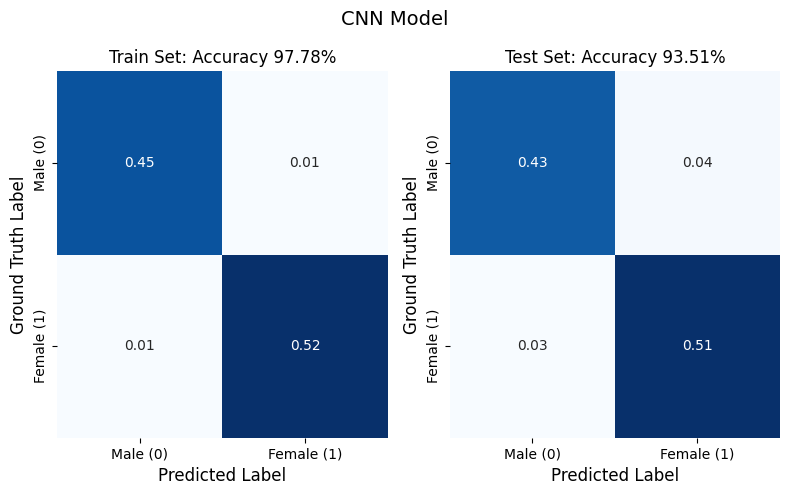

In [587]:
cnn_train_cms, cnn_test_cms = evaluate(cnn_result)
plot_confusion_matrix(cnn_train_cms, cnn_test_cms, "CNN Model")

##### 2.4 RNN Method

#### 3. Result

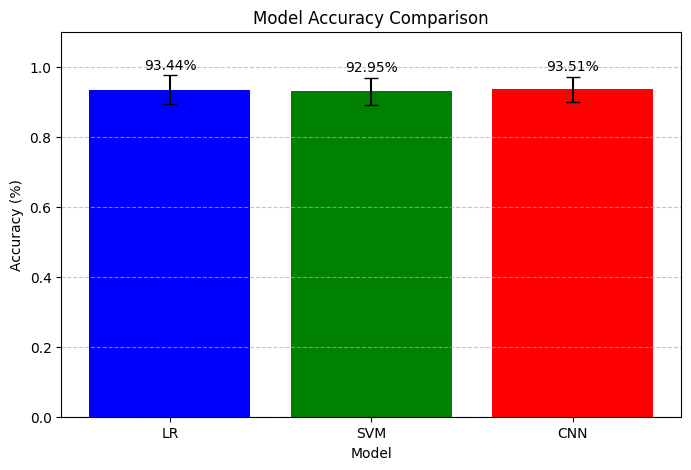

In [579]:
def get_acc(cm):
    return np.trace(cm) / np.sum(cm)

models = ['LR', 'SVM', 'CNN']
test_cms_list = [lr_test_cms, svm_test_cms, cnn_test_cms]
accs = []
stds = []
for model in zip(models, test_cms_list):
    model_name, test_cms = model
    acc = [ get_acc(cm) for cm in test_cms]
    accs.append(np.mean(acc))
    stds.append(np.std(acc))

# Plot accuracies
plt.figure(figsize=(8, 5))
plt.bar(models, accs, color=['blue', 'green', 'red'], yerr=stds, capsize=5)
# Add text annotations
for i, acc in enumerate(accs):
    plt.text(i, acc + stds[i] + 0.01, f"{acc*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1.1)  # Set y-axis limit to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()